In [ ]:
# !pip install qiskit 
!pip install pylatexenc

In [1]:
import qiskit as qk
from qiskit.algorithms import optimizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris as iris
from typing import Optional,Callable,NoReturn,NewType,Any,List,Dict,Union,Tuple
import math
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit,execute
import qiskit.tools.jupyter
%qiskit_version_table

In [2]:
def create_circuit(width,depth):
    circuit=qk.QuantumCircuit(width)
    depth_now=0
    parameter=[qk.circuit.Parameter('p%02d'%i) for i in range(3)]
    theta=[qk.circuit.Parameter('/theta%02d'%i)for i in range(depth*width)]
    '''
    for i,o in enumerate(parameter):
        circuit.ry(o,i%width)
    for i in range(width):
        for j in range(width):
            if j>i:
                circuit.cx(i,j)
    circuit.barrier()
    '''
    
    for i in range(depth):
        for j in range(width):
            circuit.ry(theta[i*width+j],j)
        if i==depth-1:continue
        for j in range(width):
            for k in range(width):
                if j>k:
                    circuit.cx(j,k)
        circuit.barrier()
    #circuit.measure_all()
    return circuit


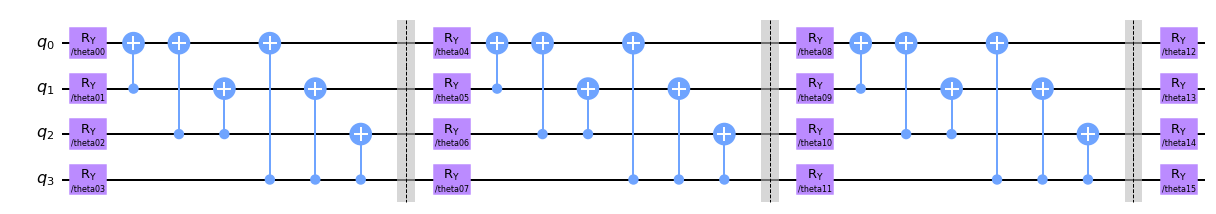

In [3]:
circuit=create_circuit(4,4)
circuit.draw('mpl')

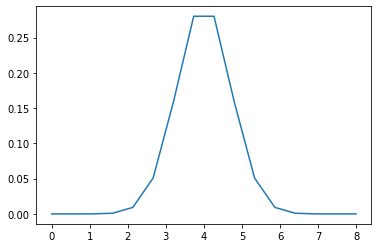

In [4]:
from sklearn.preprocessing import normalize

def gaussian(mu, sigma, x):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))

num_point = 16

x = np.linspace(0, 8, num_point)
y = gaussian(4,1, x)
y = normalize(y[:,np.newaxis], axis=0).ravel()**2
plt.plot(x, y)

In [5]:
from qiskit.visualization import circuit_visualization
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian,CircuitGradient
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
simulator=qk.BasicAer.get_backend('statevector_simulator')

def model(theta):
    global circuit,param,loss_record,result,record_result,loss_record
    param=theta
    parameter=theta
    circuit_n=circuit.assign_parameters({circuit.parameters[i]:o\
                                           for i,o in enumerate(parameter)})
    job=execute(circuit_n,simulator)
    result=job.result().get_statevector().real**2
    record_result.append(result)
    loss=sum((y-result)**2)
    loss_record.append(loss)
    #plt.plot(result.real)
    #plt.plot(y)
    #plt.show()
    print(loss)
    return loss

In [6]:
def gradient(f,x,eps=1e-8):
    x=np.array(x,dtype=float)
    gradient=[]
    for i,o in enumerate(x):
        x_p=x.copy()
        x_m=x.copy()
        x_p[i]+=eps
        x_m[i]-=eps
        gradient.append((f(x_p)-f(x_m))/2/eps)
    return gradient

In [7]:
loss_record=[]
record_result=[]
adam = optimizers.ADAM(lr=0.02,eps=1e-10)
result = adam.minimize(model,np.random.uniform(-7,7,16))

0.30274622518308436
0.3027462251865747
0.3027462251751472
0.3027462251777872
0.30274622516028754
0.3027462251986184
0.30274622519804373
0.3027462251788861
0.3027462252079226
0.30274622517736954
0.30274622518260585
0.30274622519176453
0.3027462252080174
0.30274622519614247
0.30274622518679056
0.30274622519870276
0.3027462251785573
0.2700964071170201
0.2700964071192363
0.2700964071098465
0.2700964071136874
0.2700964070976396
0.27009640713011707
0.27009640713005706
0.2700964071145779
0.2700964071382916
0.27009640711149163
0.2700964071178905
0.270096407124998
0.27009640713834376
0.2700964071283558
0.2700964071209948
0.27009640713106997
0.27009640711166405
0.24213847381784645
0.24213847381892376
0.2421384738109792
0.24213847381624692
0.24213847380191003
0.24213847382841422
0.24213847382922618
0.24213847381692058
0.24213847383563744
0.24213847381277054
0.24213847381990633
0.24213847382523943
0.24213847383563353
0.24213847382740106
0.24213847382238518
0.24213847383039688
0.24213847381213693
0

KeyboardInterrupt: 

In [ ]:
plt.plot(result)
plt.plot(y, '--')
plt.legend(['Circuit output', 'Gaussian'])
plt.savefig(fname='final_output.pdf', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)

In [ ]:
plt.plot(loss_record[:3600])
plt.legend(['loss'])
plt.savefig(fname='loss.pdf', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio

def plot_for_offset(index, y_max=0.4):
    # Data for plotting
    
    s = record_result[index]

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(s)
    ax.plot(y, '--')
    ax.set(title='Learning process')
    plt.legend(['Circuit output', 'Gaussian'])

    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant
    ax.set_ylim(0, y_max)

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./learning_process.gif', [plot_for_offset(i*6) for i in range(600)], fps=60)